In [181]:
import matplotlib.image as mpimg
import scipy.misc as spmisc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# NOTE: the next import is only valid
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [2]:
%matplotlib inline

# Load Data

In [3]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

In [45]:
default_color_space = 'RGB'
def read_image(file):
    return spmisc.imread(file, mode=default_color_space)

In [41]:
def read_image_data(path):
    files = glob.glob(path)
    images = np.array([read_image(f) for f in files])
    return files, images

In [42]:
# Read in vehicles data
car_files, car_images = read_image_data('data/vehicles/*/*.*')

print('number of car files: {}'.format(len(car_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in car_files])))
print('car images array shape: {}'.format(car_images.shape))

number of car files: 8792
unique file extensions: ['.png']
car images array shape: (8792, 64, 64, 3)


In [43]:
# Read in NON-vehicles data
noncar_files, noncar_images = read_image_data('data/non-vehicles/*/*.*')

print('number of non-car files: {}'.format(len(noncar_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in noncar_files])))
print('non-car images array shape: {}'.format(noncar_images.shape))

number of non-car files: 9666
unique file extensions: ['.png']
non-car images array shape: (9666, 64, 64, 3)


In [44]:
# combine data. the classes are quite balanced
allimages = np.vstack([car_images, noncar_images])
alllabels = np.hstack([np.ones(len(car_images)), np.zeros(len(noncar_images))]).astype(np.uint8)

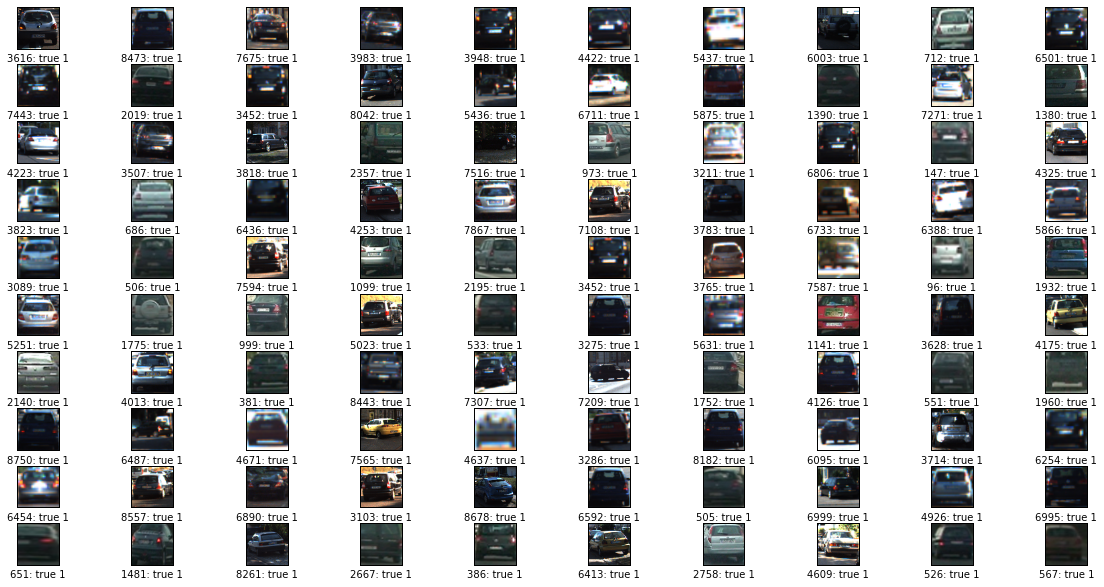

In [8]:
# cars
show_images(allimages, alllabels, 10, 10, cls=1)

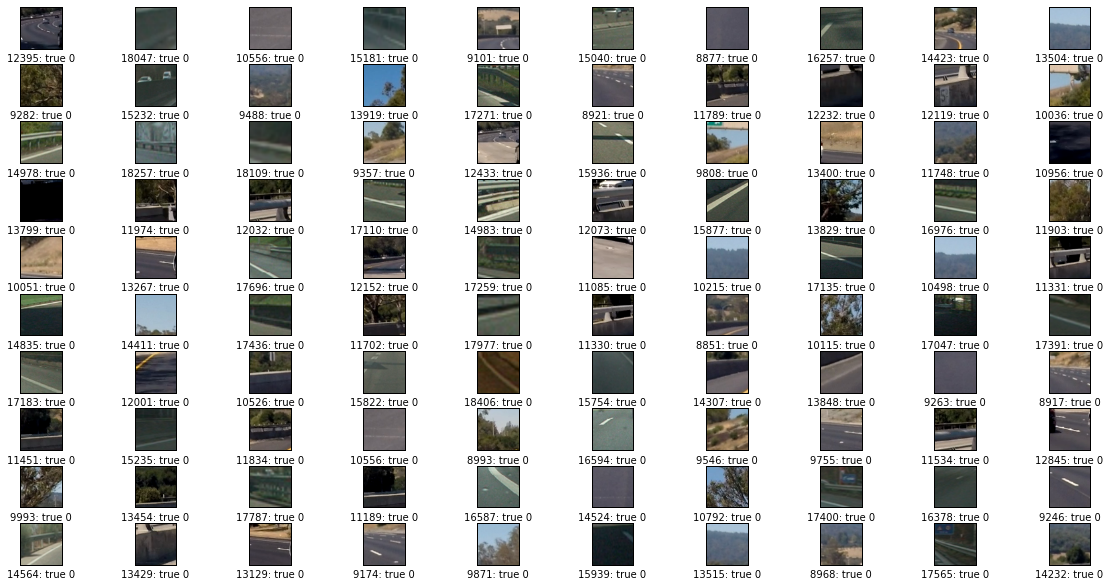

In [9]:
# NON-cars
show_images(allimages, alllabels, 10, 10, cls=0)

# test images

In [75]:
image = read_image('test_images/test3.jpg')
image.shape

(720, 1280, 3)

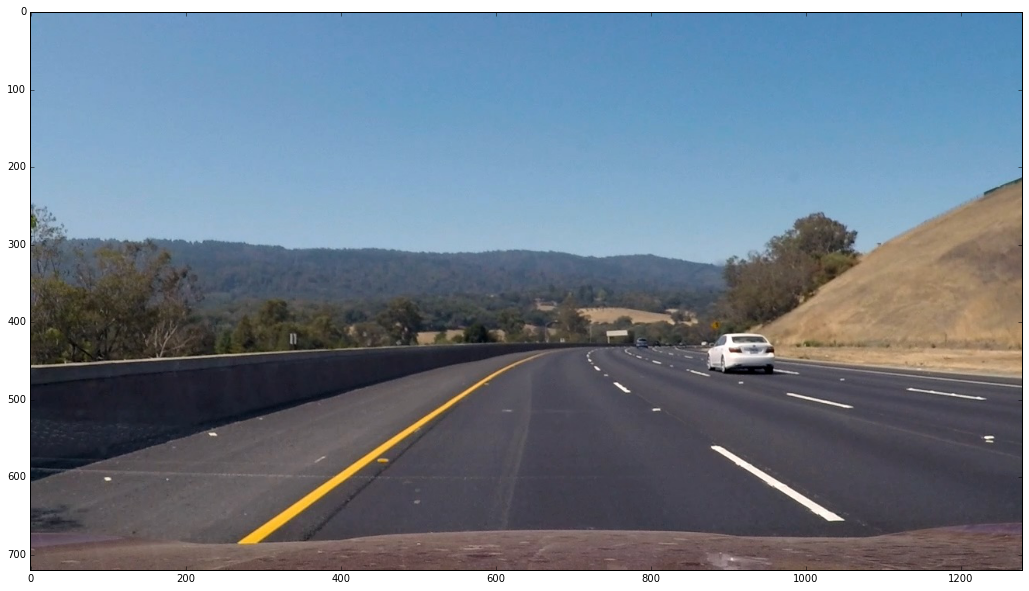

In [124]:
plt.imshow(image);

In [125]:
carimage = car_images[100]

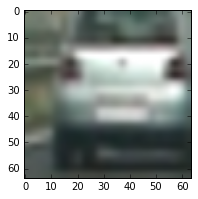

In [126]:
plt.figure(figsize=(3,3))
plt.imshow(carimage);

# define features

## spatial features

In [127]:
def convert_color(img, from_colorspace=default_color_space, to_colorspace=default_color_space):
    if (from_colorspace==to_colorspace):
        tmpimg = img
    else:
        cv2color = eval('cv2.COLOR_'+from_colorspace+'2'+to_colorspace)
        tmpimg = cv2.cvtColor(img, cv2color)
    return tmpimg

In [145]:
def image_resize(img, size):
    small_img = cv2.resize(img, size)
    return small_img

In [166]:
# compute spatial features (essentially image pixels)
# Pass the color_space flag as 3-letter all caps string like 'HSV' or 'LUV' etc.    
def features_spatial(img, size=(32, 32), feature_vec=True):
    small_img = image_resize(img, size)
    if feature_vec:
        features = small_img.ravel()
    else:
        features = small_img
    return features

In [151]:
small_image_size = (32,32)
spatial_colorspace='HLS'
feature_vec=True

In [152]:
feature_vec = features_spatial(carimage, color_space=spatial_colorspace, size=small_image_size, feature_vec=feature_vec)
feature_vec.shape

(3072,)

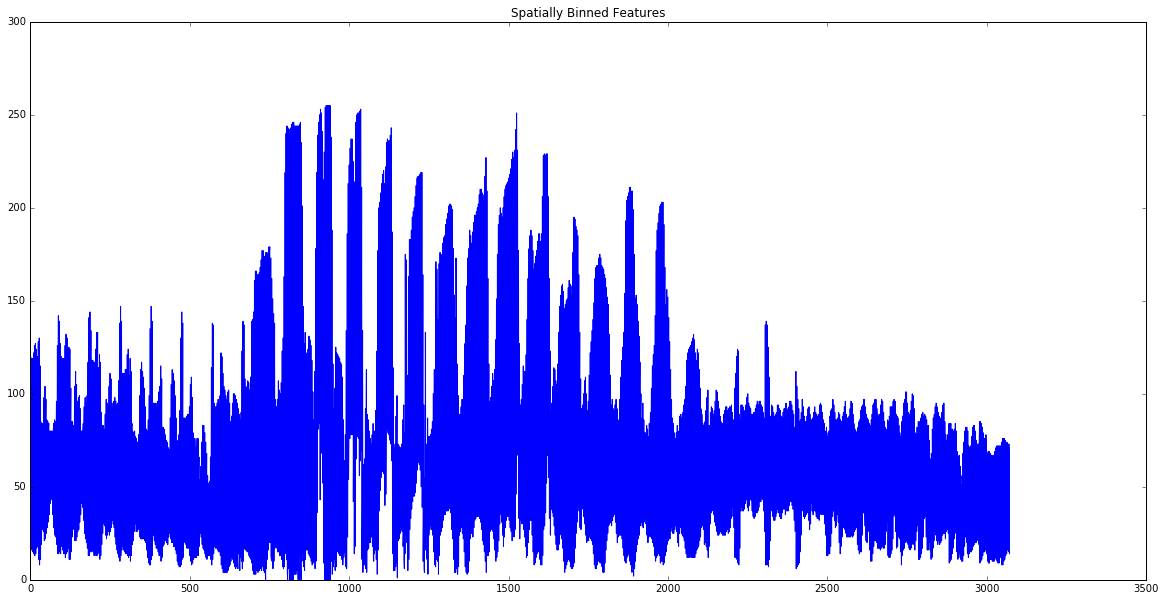

In [153]:
plt.plot(feature_vec)
plt.title('Spatially Binned Features');

## color histogram features

In [167]:
# compute color histogram features  
def features_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [155]:
num_color_bins = 32
color_bins_range = (0,256)

In [156]:
feature_vec = features_color_hist(carimage, nbins=num_color_bins, bins_range=color_bins_range)
feature_vec.shape

(96,)

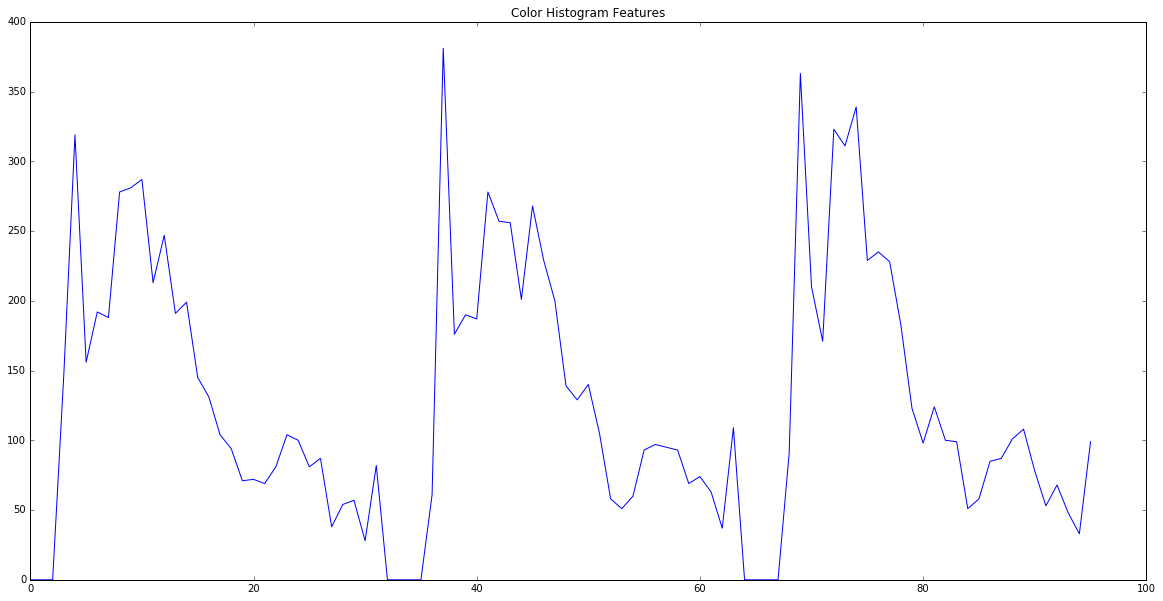

In [157]:
plt.plot(feature_vec)
plt.title('Color Histogram Features');

## HOG features

In [158]:
# HOG features and (optionally) visualization
def features_hog(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # skimage.hog()
    r = hog(img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell,pix_per_cell),
            cells_per_block = (cell_per_block,cell_per_block),
            visualise = vis,
            transform_sqrt=True, # gamma correction
            feature_vector = feature_vec)
    if vis == True:
        features, hog_image = r
        return features, hog_image
    else:      
        features = r
        return features

In [159]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

In [39]:
#Patrick Kern [1:57 AM]
#Anyone played around with opencvs hog extractor? It is way faster. Like 20 times. Unfortunately I get significant worse results on my LinearSMV compared to skimages hog features. auc 0.995 vs 0.966. (edited)
# Good to know that it's just skimages hog thats slow and not hog in general
#Patrick Kern [3:44 PM]
#I also did a second gridsearch with the opencv hog extractor which has more parameters. I ended up with 30,000 fits which took 2750 min but still had worse accuracy than the skimage hog extractor

#@rushabh: couple of things you can implement to speed up your pipeline. 
#1) use a region of interest and only hog that portion of the image 
#2) make sure you extract hog as a feature matrix 
#3) make sure your sliding window overlap is not to much 
#4) keep feature vector at around 3000-5000 features. Less is better 
#5) only check the images at two scales 
#6) create an average heat map


In [160]:
gray_image = cv2.cvtColor(carimage, cv2.COLOR_RGB2GRAY)

In [161]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=False)

CPU times: user 12.9 ms, sys: 2.27 ms, total: 15.2 ms
Wall time: 14.2 ms


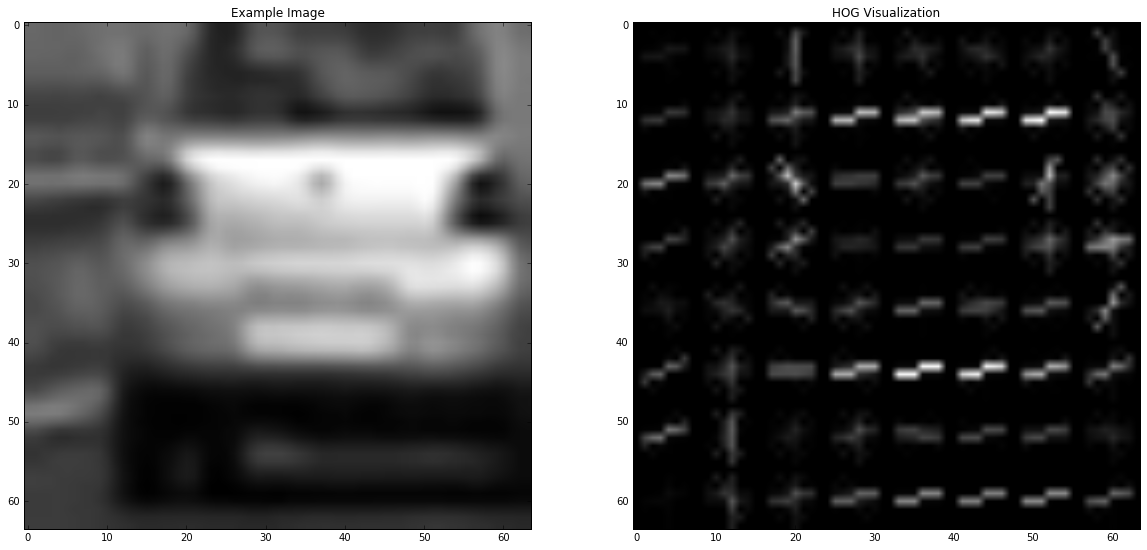

In [162]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

In [163]:
# convert to gray
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# only use lower half of the image
h, w = gray_image.shape
gray_image = gray_image[h//2:, :]

In [164]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=False)

CPU times: user 1.29 s, sys: 14.1 ms, total: 1.3 s
Wall time: 1.31 s


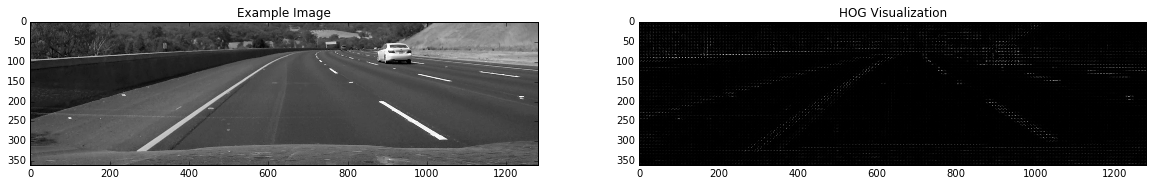

In [165]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

## combine and normalise features

In [171]:
def extract_features(images, 
                     to_colorspace='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256),
                     hog_orient=9,
                     hog_pix_per_cell=8, 
                     hog_cell_per_block=2, 
                     hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in images:
        tmpimg = convert_color(img, default_color_space, to_colorspace)
        
        spfeat = features_spatial(tmpimg, spatial_size, feature_vec=True)
        
        hfeat = features_color_hist(tmpimg, hist_bins, hist_range)
                
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hogfeat = []
            for channel in range(tmpimg.shape[2]):
                hogfeat.append(features_hog(tmpimg[:,:,channel], 
                                                   hog_orient, 
                                                   hog_pix_per_cell, 
                                                   hog_cell_per_block, 
                                                   vis=False, 
                                                   feature_vec=True))
            hogfeat = np.ravel(hogfeat)        
        else:
            hogfeat = features_hog(tmpimg[:,:,hog_channel], 
                                   hog_orient, 
                                   hog_pix_per_cell, 
                                   hog_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)        
        
        features.append(np.concatenate((spfeat, hfeat, hogfeat)))
    return features


In [172]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
hog_orient = 9
hog_pix_per_cell = 8
hog_cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

In [173]:
allfeatures = extract_features(allimages, 
                                 to_colorspace=colorspace, 
                                 spatial_size=spatial_size,
                                 hist_bins=hist_bins, 
                                 hist_range=hist_range,
                                 hog_orient=hog_orient,
                                 hog_pix_per_cell=hog_pix_per_cell, 
                                 hog_cell_per_block=hog_cell_per_block, 
                                 hog_channel=hog_channel)
# Create an array stack of feature vectors
# NOTE: StandardScaler() expects np.float64 
allfeatures = np.array(allfeatures).astype(np.float64)

In [174]:
allfeatures.shape

(18458, 4932)

In [176]:
feature_scaler = StandardScaler().fit(allfeatures)
scaled_features = feature_scaler.transform(allfeatures)

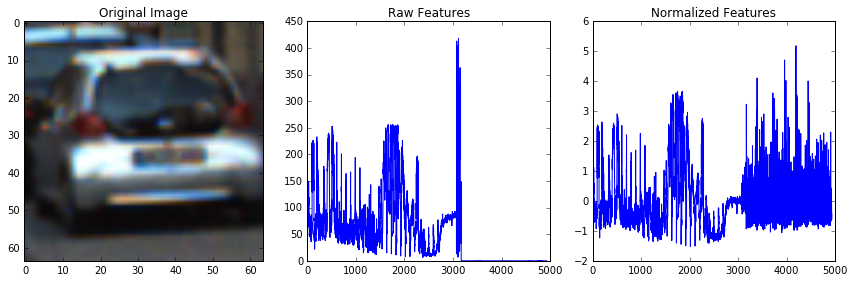

In [179]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_images[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(allfeatures[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_features[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## train classifier

In [182]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, alllabels, test_size=0.2, random_state=rand_state)

In [184]:
print('Colorspace: '+colorspace)
print('Spatial binning size: {}'.format(spatial_size))
print('Color histogram bins: {}'.format(hist_bins))
print('Color histogram range: {}'.format(hist_range))
print('HOG orient: {}'.format(hog_orient))
print('HOG pix per cell: {}'.format(hog_pix_per_cell))
print('HOG cells per block: {}'.format(hog_cell_per_block))
print('HOG challen: {}'.format(hog_channel))
print('Feature vector length: {}'.format(len(X_train[0])))

svc = LinearSVC()
%time svc.fit(X_train, y_train)

Colorspace: RGB
Spatial binning size: (32, 32)
Color histogram bins: 32
Color histogram range: (0, 256)
HOG orient: 9
HOG pix per cell: 8
HOG cells per block: 2
HOG challen: 0
Feature vector length: 4932
CPU times: user 11.6 s, sys: 674 ms, total: 12.3 s
Wall time: 12.9 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [186]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

n_predict = 10
%time pred = svc.predict(X_test[0:n_predict])
print('Predicted: {}'.format(pred               ))
print('Actual   : {}'.format(y_test[0:n_predict]))

Test Accuracy of SVC =  0.9805
CPU times: user 807 µs, sys: 115 µs, total: 922 µs
Wall time: 237 µs
Predicted: [0 0 1 1 0 0 1 0 0 0]
Actual   : [0 0 1 1 0 0 1 0 0 0]


## sliding windows

In [ ]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    h, w, _ = img.shape
    if x_start_stop[0] is None:
        x_start = 0
    else:
        x_start = x_start_stop[0]
    if y_start_stop[0] is None:
        y_start = 0
    else:
        y_start = y_start_stop[0]
    if x_start_stop[1] is None:
        x_stop = w
    else:
        x_stop = x_start_stop[1]
    if y_start_stop[1] is None:
        y_stop = h
    else:
        y_stop = y_start_stop[1]
    # Compute the span of the region to be searched
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    # Compute the number of pixels per step in x/y
    x_step = int(xy_window[0]*xy_overlap[0])
    y_step = int(xy_window[1]*xy_overlap[1])
    # Compute the number of windows in x/y
    x_windows = x_span // x_step
    y_windows = y_span // y_step
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for x in range(x_start,x_stop,x_step):
        for y in range(y_start,y_stop,y_step):
            #     Note: you could vectorize this step, but in practice
            #     you'll be considering windows one by one with your
            #     classifier, so looping makes sense
            # Calculate each window position
            window = ((x,y),(x+x_step,y+y_step))
            # Append window position to list
            window_list.append(window)
    # Return the list of windows
    return window_list

In [ ]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [ ]:
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## search and classify

In [ ]:
# Two new functions are defined: single_img_features() and search_windows(). 
# You can use these to search over all the windows defined by your slide_windows(), 
# extract features at each window position, and predict with your classifier on each set of features.

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [ ]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [ ]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [ ]:
# In practice, you will want to integrate a heat map over several frames of video, 
# such that areas of multiple detections get "hot", while transient false positives stay "cool". 
# You can then simply threshold your heatmap to remove false positives


In [ ]:
Once you have a thresholded heat-map, there are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements. You'll use it like this:

from scipy.ndimage.measurements import label
labels = label(heatmap)
Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')


In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)